## Load the Data

In [122]:
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTEN, BorderlineSMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

from mord import LogisticAT

In [108]:
pd.set_option('display.max_columns', None)

In [109]:
# df_2022 = pd.read_csv('../data/new/feature_selection/feature_selection-2022.csv', sep=';')
# test = [pd.read_csv(f'../data/new/feature_selection/feature_selection-{year}.csv', sep=';') for year in [2019, 2020, 2021]]
# df = pd.concat([df_2022] + [x[x['injury_severity'] == 4] for x in test])

df = pd.concat([pd.read_csv(f'../data/new/feature_selection/feature_selection-{year}.csv', sep=';') for year in [2019, 2020, 2021, 2022]])
df_test = pd.read_csv('../data/new/feature_selection/feature_selection-2023.csv', sep=';')

In [8]:
df

,day,month,lighting_condition,location,intersection,weather_condition,type_of_collision,latitude,longitude,road_category,traffic_regime,number_of_traffic_lanes,reserved_lane_present,longitudinal_profile,horizontal_alignment,pavement_condition,infrastructure,accident_situation,speed_limit,position,user_category,injury_severity,sex,pedestrian_location,pedestrian_action,direction_of_travel,vehicle_category,fixed_obstacle_struck,mobile_obstacle_struck,initial_point_of_impact,main_maneuver_before_accident,motor_type,direction_of_travel_other,vehicle_category_other,fixed_obstacle_struck_other,mobile_obstacle_struck_other,initial_point_of_impact_other,main_maneuver_before_accident_other,motor_type_other,vehicle_category_involved_bicycle,vehicle_category_involved_bus_coach,vehicle_category_involved_hgv_truck,vehicle_category_involved_light_motor_vehicle,vehicle_category_involved_other,vehicle_category_involved_powered_2_3_wheeler,hour,minute,age,used_belt,used_helmet,used_child_restraint,used_airbag
0,30,11,4,1,1,1,2,48.896210,2.470120,1,3,10.0,0,1,2,1,2,1,70,2,2,4,2,-1,-1,2.0,light_motor_vehicle,0.0,2.0,5.0,23.0,1.0,2.0,hgv_truck,1.0,0.0,3.0,11.0,1.0,0,0,1,1,0,0,1,30,17.0,1,0,0,0
1,30,11,4,1,1,1,2,48.896210,2.470120,1,3,10.0,0,1,2,1,2,1,70,1,1,4,2,-1,-1,2.0,light_motor_vehicle,0.0,2.0,5.0,23.0,1.0,2.0,hgv_truck,1.0,0.0,3.0,11.0,1.0,0,0,1,1,0,0,1,30,26.0,1,0,0,0
2,30,11,4,1,1,1,2,48.896210,2.470120,1,3,10.0,0,1,2,1,2,1,70,1,1,1,1,-1,-1,2.0,hgv_truck,1.0,0.0,3.0,11.0,1.0,2.0,light_motor_vehicle,0.0,2.0,5.0,23.0,1.0,0,0,1,1,0,0,1,30,60.0,1,0,0,0
3,30,11,3,1,1,1,6,48.930700,2.368800,1,1,2.0,0,4,2,1,0,1,70,1,1,4,2,-1,-1,1.0,light_motor_vehicle,4.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,2,50,25.0,1,0,0,0
4,28,11,1,1,1,1,4,48.935872,2.319174,1,3,8.0,0,1,3,1,0,1,90,1,1,1,1,-1,0,1.0,light_motor_vehicle,0.0,2.0,1.0,2.0,1.0,1.0,light_motor_vehicle,0.0,2.0,4.0,23.0,6.0,0,0,0,3,0,0,15,15,23.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126657,1,1,1,1,3,1,3,43.927265,1.915637,3,2,2.0,0,1,1,1,0,1,80,1,1,1,2,0,0,2.0,light_motor_vehicle,0.0,0.0,8.0,19.0,1.0,2.0,light_motor_vehicle,0.0,2.0,1.0,1.0,1.0,0,0,0,2,0,0,8,40,20.0,1,0,0,0
126658,1,1,1,1,3,1,3,43.927265,1.915637,3,2,2.0,0,1,1,1,0,1,80,8,2,3,2,0,0,2.0,light_motor_vehicle,0.0,0.0,8.0,19.0,1.0,2.0,light_motor_vehicle,0.0,2.0,1.0,1.0,1.0,0,0,0,2,0,0,8,40,18.0,1,0,0,0
126659,1,1,1,1,3,1,3,43.927265,1.915637,3,2,2.0,0,1,1,1,0,1,80,1,1,4,2,0,0,2.0,light_motor_vehicle,0.0,2.0,1.0,1.0,1.0,2.0,light_motor_vehicle,0.0,0.0,8.0,19.0,1.0,0,0,0,2,0,0,8,40,69.0,1,0,0,0
126660,1,3,1,2,1,1,2,47.594404,1.353329,3,3,4.0,0,1,1,1,0,1,70,1,1,3,1,-1,-1,1.0,powered_2_3_wheeler,0.0,2.0,1.0,1.0,1.0,1.0,light_motor_vehicle,0.0,0.0,4.0,21.0,1.0,0,0,0,1,0,1,16,55,30.0,0,1,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 494182 entries, 0 to 126661
Data columns (total 52 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   day                                            494182 non-null  int64  
 1   month                                          494182 non-null  int64  
 2   lighting_condition                             494182 non-null  int64  
 3   location                                       494182 non-null  int64  
 4   intersection                                   494182 non-null  int64  
 5   weather_condition                              494182 non-null  int64  
 6   type_of_collision                              494182 non-null  int64  
 7   latitude                                       494182 non-null  float64
 8   longitude                                      494182 non-null  float64
 9   road_category                             

In [10]:
# AI generated helper function
def not_reported_summary(
        df: pd.DataFrame,
        zeros_as_na_cols=None,  # columns where 0 means "Sans objet/Aucun"
        extra_markers_by_col=None  # dict like {"col": {"-9","99"}}
) -> pd.DataFrame:
    zeros_as_na_cols = set(zeros_as_na_cols or [])
    extra_markers_by_col = extra_markers_by_col or {}

    rows = []
    for col in df.columns:
        s = df[col]

        # work on strings to catch both string and numeric codes
        s_str = s.astype(str).str.strip()
        s_num = pd.to_numeric(s_str, errors="coerce")

        nulls = s.isna().sum()
        blanks = (s_str == "").sum()
        dots = (s_str == ".").sum()
        minus1 = (s_num == -1).sum()  # "-1 = Non renseigné" in many fields
        zero_na = ((s_num == 0) | (s_str == "0")).sum() if col in zeros_as_na_cols else 0

        # column-specific extra markers (e.g., {"grav": {"9"}, "trajet": {"0"}})
        extras = 0
        if col in extra_markers_by_col:
            extras = s_str.isin(set(extra_markers_by_col[col])).sum()

        any_na = nulls + blanks + dots + minus1 + zero_na + extras
        pct = any_na / len(df) * 100 if len(df) else 0

        rows.append({
            "column": col,
            "rows": len(df),
            "null": int(nulls),
            "blank": int(blanks),
            "dot(.)": int(dots),
            "-1_not_reported": int(minus1),
            "zero_as_na": int(zero_na),
            "extra_markers": int(extras),
            "any_missing_like": int(any_na),
            "any_missing_like_pct": round(pct, 2),
        })

    out = pd.DataFrame(rows).sort_values("any_missing_like_pct", ascending=False)
    return out

In [11]:
not_reported_summary(df)

,column,rows,null,blank,dot(.),-1_not_reported,zero_as_na,extra_markers,any_missing_like,any_missing_like_pct
23,pedestrian_location,494182,0,0,0,216753,0,0,216753,43.86
24,pedestrian_action,494182,0,0,0,185666,0,0,185666,37.57
32,direction_of_travel_other,494182,105842,0,0,0,0,0,105842,21.42
38,motor_type_other,494182,105393,0,0,0,0,0,105393,21.33
35,mobile_obstacle_struck_other,494182,104691,0,0,0,0,0,104691,21.18
36,initial_point_of_impact_other,494182,104683,0,0,0,0,0,104683,21.18
37,main_maneuver_before_accident_other,494182,104596,0,0,0,0,0,104596,21.17
34,fixed_obstacle_struck_other,494182,104637,0,0,0,0,0,104637,21.17
33,vehicle_category_other,494182,104483,0,0,0,0,0,104483,21.14
25,direction_of_travel,494182,40059,0,0,0,0,0,40059,8.11


## Some Preprocessing

In [110]:
columns_to_drop = [
    'pedestrian_location', 'pedestrian_action', # Too many na values.
    'day', 'month', 'latitude', 'longitude', 'hour', 'minute'
]

na_with_meaning = [
    'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type',
    'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other', 'motor_type_other',
    'age', 'sex', 'direction_of_travel', 'direction_of_travel_other'
]

extra = ['vehicle_category', 'vehicle_category_other']


for x in [df, df_test]:
    # Remove rows or columns with missing values that do not encode info.
    x.drop(columns=columns_to_drop, inplace=True)
    x.replace(-1, pd.NA, inplace=True)
    x[na_with_meaning] = x[na_with_meaning].fillna(-1)
    x[extra] = x[extra].fillna('no vehicle')
    x.dropna(inplace=True)

    # Make sure injury severity score is ascending
    x['injury_severity'] = x['injury_severity'].map({1:1, 2:4, 3:3, 4:2}) # Mapping injury severity to be ordinal ascending.
    x[x.columns.difference(extra)] = x[x.columns.difference(extra)].astype(int)



C:\Users\David\AppData\Local\Temp\ipykernel_3444\1899168234.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[na_with_meaning] = x[na_with_meaning].fillna(-1)
C:\Users\David\AppData\Local\Temp\ipykernel_3444\1899168234.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[na_with_meaning] = x[na_with_meaning].fillna(-1)


In [13]:
not_reported_summary(df)

,column,rows,null,blank,dot(.),-1_not_reported,zero_as_na,extra_markers,any_missing_like,any_missing_like_pct
26,direction_of_travel_other,450502,0,0,0,95734,0,0,95734,21.25
32,motor_type_other,450502,0,0,0,95085,0,0,95085,21.11
29,mobile_obstacle_struck_other,450502,0,0,0,94719,0,0,94719,21.03
30,initial_point_of_impact_other,450502,0,0,0,94699,0,0,94699,21.02
28,fixed_obstacle_struck_other,450502,0,0,0,94677,0,0,94677,21.02
31,main_maneuver_before_accident_other,450502,0,0,0,94638,0,0,94638,21.01
19,direction_of_travel,450502,0,0,0,35192,0,0,35192,7.81
25,motor_type,450502,0,0,0,34331,0,0,34331,7.62
22,mobile_obstacle_struck,450502,0,0,0,34096,0,0,34096,7.57
23,initial_point_of_impact,450502,0,0,0,34049,0,0,34049,7.56


In [111]:
X_train = df.drop(columns='injury_severity')
y_train = df['injury_severity']

In [112]:
X_test = df_test.drop(columns='injury_severity')
y_test = df_test['injury_severity']

In [113]:
X_train

,lighting_condition,location,intersection,weather_condition,type_of_collision,road_category,traffic_regime,number_of_traffic_lanes,reserved_lane_present,longitudinal_profile,horizontal_alignment,pavement_condition,infrastructure,accident_situation,speed_limit,position,user_category,sex,direction_of_travel,vehicle_category,fixed_obstacle_struck,mobile_obstacle_struck,initial_point_of_impact,main_maneuver_before_accident,motor_type,direction_of_travel_other,vehicle_category_other,fixed_obstacle_struck_other,mobile_obstacle_struck_other,initial_point_of_impact_other,main_maneuver_before_accident_other,motor_type_other,vehicle_category_involved_bicycle,vehicle_category_involved_bus_coach,vehicle_category_involved_hgv_truck,vehicle_category_involved_light_motor_vehicle,vehicle_category_involved_other,vehicle_category_involved_powered_2_3_wheeler,age,used_belt,used_helmet,used_child_restraint,used_airbag
0,4,1,1,1,2,1,3,10,0,1,2,1,2,1,70,2,2,2,2,light_motor_vehicle,0,2,5,23,1,2,hgv_truck,1,0,3,11,1,0,0,1,1,0,0,17,1,0,0,0
1,4,1,1,1,2,1,3,10,0,1,2,1,2,1,70,1,1,2,2,light_motor_vehicle,0,2,5,23,1,2,hgv_truck,1,0,3,11,1,0,0,1,1,0,0,26,1,0,0,0
2,4,1,1,1,2,1,3,10,0,1,2,1,2,1,70,1,1,1,2,hgv_truck,1,0,3,11,1,2,light_motor_vehicle,0,2,5,23,1,0,0,1,1,0,0,60,1,0,0,0
3,3,1,1,1,6,1,1,2,0,4,2,1,0,1,70,1,1,2,1,light_motor_vehicle,4,0,1,0,1,-1,no vehicle,-1,-1,-1,-1,-1,0,0,0,1,0,0,25,1,0,0,0
4,1,1,1,1,4,1,3,8,0,1,3,1,0,1,90,1,1,1,1,light_motor_vehicle,0,2,1,2,1,1,light_motor_vehicle,0,2,4,23,6,0,0,0,3,0,0,23,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126657,1,1,3,1,3,3,2,2,0,1,1,1,0,1,80,1,1,2,2,light_motor_vehicle,0,0,8,19,1,2,light_motor_vehicle,0,2,1,1,1,0,0,0,2,0,0,20,1,0,0,0
126658,1,1,3,1,3,3,2,2,0,1,1,1,0,1,80,8,2,2,2,light_motor_vehicle,0,0,8,19,1,2,light_motor_vehicle,0,2,1,1,1,0,0,0,2,0,0,18,1,0,0,0
126659,1,1,3,1,3,3,2,2,0,1,1,1,0,1,80,1,1,2,2,light_motor_vehicle,0,2,1,1,1,2,light_motor_vehicle,0,0,8,19,1,0,0,0,2,0,0,69,1,0,0,0
126660,1,2,1,1,2,3,3,4,0,1,1,1,0,1,70,1,1,1,1,powered_2_3_wheeler,0,2,1,1,1,1,light_motor_vehicle,0,0,4,21,1,0,0,0,1,0,1,30,0,1,0,0


In [88]:
num_cols = ['age', 'number_of_traffic_lanes', 'speed_limit']
cat_cols = X_train.columns.difference(num_cols)

# cat_cols = [
#     'lighting_condition', 'location', 'intersection', 'weather_condition', 'type_of_collision', 'road_category', 'traffic_regime', 'reserved_lane_present', 'longitudinal_profile',
#     'horizontal_alignment', 'pavement_condition', 'infrastructure', 'accident_situation', 'user_category', 'sex', 'direction_of_travel', 'vehicle_category', 'fixed_obstacle_struck',
#     'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type', 'direction_of_travel_other', 'vehicle_category_other', 'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other',
#     'initial_point_of_impact_other', 'main_maneuver_before_accident_other', 'motor_type_other'
# ]
#num_cols = X_train.columns.difference(cat_cols)

## Model Exploration

### Baseline: K-NN Classifier with Resampling

In [ ]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols),
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('pre', transformer),
    ('os', BorderlineSMOTE(k_neighbors=NearestNeighbors(n_jobs=-1), m_neighbors=NearestNeighbors(n_jobs=-1))),  # try RandomUnderSampler() or SMOTE for numeric-only
    ('clf', KNeighborsClassifier(n_neighbors=20, n_jobs=-1)),
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [25, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
print(classification_report(y_test, y_pred, target_names=['not injured', 'slightly injured', 'heavily injured', 'killed']))

### Logistic Regression

In [14]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('pre', transformer),
    ('os', BorderlineSMOTE(k_neighbors=NearestNeighbors(n_jobs=-1), m_neighbors=NearestNeighbors(n_jobs=-1), random_state=42, sampling_strategy='minority')),  # try RandomUnderSampler() or SMOTE for numeric-only
    ('clf', LogisticRegression(max_iter=100, n_jobs=-1, class_weight={1:1, 2:2, 3:3, 4:5}, penalty='l2')),
])
pipeline.fit(X_train, y_train)

,steps,"[('pre', ...), ('os', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
y_predict = pipeline.predict(X_test)
print(classification_report(y_test, y_predict))

c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [32] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           1       0.87      0.53      0.66     48829
           2       0.57      0.64      0.60     45378
           3       0.36      0.04      0.08     17845
           4       0.08      0.82      0.15      3143

    accuracy                           0.51    115195
   macro avg       0.47      0.51      0.37    115195
weighted avg       0.65      0.51      0.53    115195



## CatBoost Model

### With Resampling

In [ ]:
from catboost import CatBoostClassifier, Pool
import numpy as np

transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols),
], remainder='passthrough')

X_train_en = transformer.fit_transform(X_train, y_train)  # returns X only
X_test_en  = transformer.transform(X_test)

resampler = BorderlineSMOTE(k_neighbors=NearestNeighbors(n_jobs=-1), m_neighbors=NearestNeighbors(n_jobs=-1))
X_train_sam, y_train_sam = resampler.fit_resample(X_train_en, y_train)  # use original y

# Do NOT pass cat_features after OHE
train_pool = Pool(X_train_sam, y_train_sam)
test_pool  = Pool(X_test_en)

model = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='TotalF1',
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced'
)
model.fit(train_pool, verbose=False)

y_pred = model.predict(test_pool)

In [ ]:
print(classification_report(y_test, y_pred))

### With Under and Oversampling

In [ ]:
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

num_cols = ['age', 'number_of_traffic_lanes', 'speed_limit']
cat_idx = [X_train.columns.get_loc(c) for c in X_train.columns if c not in num_cols]

over = SMOTENC(categorical_features=cat_idx, sampling_strategy='minority', random_state=42, n_jobs=-1)
under = RandomUnderSampler(sampling_strategy='majority', random_state=42)

X_res, y_res = over.fit_resample(X_train, y_train)
X_res, y_res = under.fit_resample(X_res, y_res)

train_pool = Pool(X_res, y_res, cat_features=cat_idx)
val_pool   = Pool(X_val, y_val, cat_features=cat_idx)
test_pool  = Pool(X_test, cat_features=cat_idx)

model = CatBoostClassifier(
    loss_function='MultiClassOneVsAll',
    task_type='GPU',
    devices='0',
    use_best_model=True,
    random_state=42
)
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=200, verbose=False)
print('Val macro-F1:', f1_score(y_val, model.predict(val_pool), average='macro'))
print(classification_report(y_test, model.predict(test_pool)))
# ...existing code...

['accident_situation',
 'direction_of_travel',
 'direction_of_travel_other',
 'fixed_obstacle_struck',
 'fixed_obstacle_struck_other',
 'horizontal_alignment',
 'infrastructure',
 'initial_point_of_impact',
 'initial_point_of_impact_other',
 'intersection',
 'lighting_condition',
 'location',
 'longitudinal_profile',
 'main_maneuver_before_accident',
 'main_maneuver_before_accident_other',
 'mobile_obstacle_struck',
 'mobile_obstacle_struck_other',
 'motor_type',
 'motor_type_other',
 'number_of_traffic_lanes',
 'pavement_condition',
 'position',
 'reserved_lane_present',
 'road_category',
 'sex',
 'speed_limit',
 'traffic_regime',
 'type_of_collision',
 'used_airbag',
 'used_belt',
 'used_child_restraint',
 'used_helmet',
 'user_category',
 'vehicle_category',
 'vehicle_category_involved_bicycle',
 'vehicle_category_involved_bus_coach',
 'vehicle_category_involved_hgv_truck',
 'vehicle_category_involved_light_motor_vehicle',
 'vehicle_category_involved_other',
 'vehicle_category_invol

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.85      0.75      0.80     48829
           2       0.67      0.59      0.62     45378
           3       0.39      0.57      0.46     17845
           4       0.16      0.29      0.20      3143

    accuracy                           0.65    115195
   macro avg       0.51      0.55      0.52    115195
weighted avg       0.69      0.65      0.66    115195



### Without Resampling

In [16]:
from catboost import CatBoostClassifier, Pool
import numpy as np

# keep only categorical columns that still exist
cat_cols = [c for c in cat_cols if c in X_train.columns]

# build 0-based positions
cat_features_idx = [X_train.columns.get_loc(c) for c in cat_cols]

train_pool = Pool(X_train, y_train, cat_features=cat_features_idx)
test_pool  = Pool(X_test, cat_features=cat_features_idx)

model = CatBoostClassifier(
    # depth=6,
    # learning_rate=0.005,
    # iterations=1600,
    loss_function='MultiClass',  # or RMSE
    eval_metric='TotalF1',
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced'
)
model.fit(train_pool, verbose=False)

y_pred = model.predict(test_pool)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.77      0.80     48829
           2       0.68      0.57      0.62     45378
           3       0.39      0.49      0.43     17845
           4       0.17      0.56      0.27      3143

    accuracy                           0.64    115195
   macro avg       0.52      0.60      0.53    115195
weighted avg       0.69      0.64      0.66    115195



### Validation Set

In [98]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
import numpy as np

# time-aware split (don’t shuffle); adjust if you prefer a year-based split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

# indices of categorical features
num_cols = ['age', 'number_of_traffic_lanes', 'speed_limit']
cat_cols = [c for c in X_train.columns if c not in num_cols]
cat_features_idx = [X_train.columns.get_loc(c) for c in cat_cols]

base = CatBoostClassifier(
    loss_function='MultiClassOneVsAll',
    task_type='GPU',
    devices='0',
    use_best_model=True,
    random_state=42,
    verbose=False
)

param_dist = {
    'depth': [5, 6, 7, 8],
    'learning_rate': np.linspace(0.02, 0.2, 6),
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'random_strength': [0.0, 0.5, 1.0, 2.0],
    'bagging_temperature': [0, 0.25, 0.5, 1.0],
    'border_count': [128, 254],
    'class_weights': [
        None,
        [1.0, 1.2, 1.5, 2.0],
        [1.0, 1.5, 2.0, 3.0]
    ],
    'iterations': [2000],  # rely on early stopping
}

# single “train-only” fold; early stopping runs on the held-out val set via fit params
clf = RandomizedSearchCV(
    estimator=base,
    param_distributions=param_dist,
    n_iter=30,
    scoring=make_scorer(f1_score, average='macro'),
    cv=[(np.arange(len(X_tr)), np.arange(len(X_tr)))],
    refit=True,
    random_state=42,
    n_jobs=1  # keep 1; CatBoost uses GPU internally
)

# IMPORTANT: pass raw X/y; forward cat_features + eval_set + early stopping here
clf.fit(
    X_tr, y_tr,
    cat_features=cat_features_idx,
    eval_set=(X_val, y_val),
    early_stopping_rounds=200,
    verbose=False
)

best_model = clf.best_estimator_

# Validate
y_val_pred = best_model.predict(X_val)
print('Val macro-F1:', f1_score(y_val, y_val_pred, average='macro'))

# Test
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None

Val macro-F1: 0.5494470410109682
              precision    recall  f1-score   support

           1       0.88      0.72      0.79     48829
           2       0.63      0.77      0.69     45378
           3       0.47      0.48      0.48     17845
           4       0.42      0.17      0.24      3143

    accuracy                           0.69    115195
   macro avg       0.60      0.53      0.55    115195
weighted avg       0.70      0.69      0.69    115195



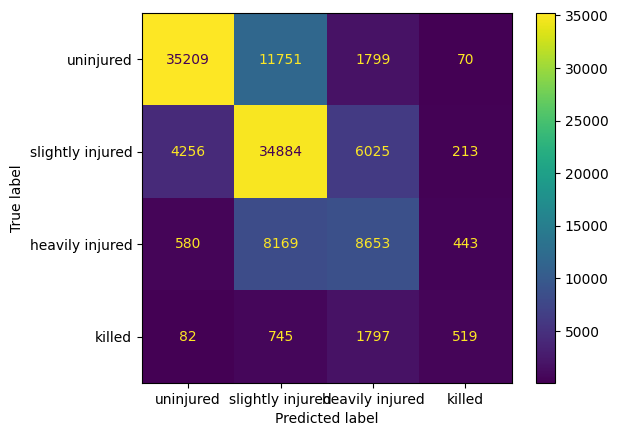

In [ ]:
ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred),
    display_labels=['uninjured', 'slightly injured', 'heavily injured', 'killed']
).plot()

In [123]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import numpy as np

# time-aware split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

# categorical feature indices
num_cols = ['age', 'number_of_traffic_lanes', 'speed_limit']
cat_cols = [c for c in X_train.columns if c not in num_cols]
cat_features_idx = [X_train.columns.get_loc(c) for c in cat_cols]

# CatBoost as regressor (ordinal target 1..4)
reg = CatBoostRegressor(
    loss_function='RMSE',
    task_type='GPU',
    devices='0',
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=3,
    random_state=42,
    verbose=False,
    cat_features = cat_features_idx
)

under_sampler = RandomUnderSampler(sampling_strategy={1:20000, 2:20000, 3:20000})
over_sampler = SMOTENC(
    categorical_features = cat_features_idx, 
    categorical_encoder=OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
    k_neighbors=NearestNeighbors(n_jobs=-1, n_neighbors=10),
    sampling_strategy={4:20000}
)

X_tr, y_tr = over_sampler.fit_resample(X_tr, y_tr)
X_tr, y_tr = under_sampler.fit_resample(X_tr, y_tr)

reg.fit(
    X_tr, y_tr,
    cat_features=cat_features_idx,
    eval_set=(X_val, y_val),
    early_stopping_rounds=200,
    verbose=False
)

# Helpers to convert continuous preds to ordinal classes
def round_clip(y_cont):
    return np.clip(np.rint(y_cont), 1, 4).astype(int)

def apply_thresholds(y_cont, t1, t2, t3):
    y = np.asarray(y_cont)
    out = np.empty_like(y, dtype=int)
    out[y < t1] = 1
    out[(y >= t1) & (y < t2)] = 2
    out[(y >= t2) & (y < t3)] = 3
    out[y >= t3] = 4
    return out

# Predict
val_cont = reg.predict(X_val)
test_cont = reg.predict(X_test)

# Baseline: simple rounding
y_val_round = round_clip(val_cont)
print('Val macro-F1 (round+clip):', f1_score(y_val, y_val_round, average='macro'))

# Tune ordinal thresholds on validation
best = (-1, (1.5, 2.5, 3.5))
g1 = np.arange(1.3, 1.8, 0.05)
g2 = np.arange(2.3, 2.8, 0.05)
g3 = np.arange(3.3, 3.8, 0.05)
for t1 in g1:
    for t2 in g2:
        if t2 <= t1: 
            continue
        for t3 in g3:
            if t3 <= t2:
                continue
            yv = apply_thresholds(val_cont, t1, t2, t3)
            score = f1_score(y_val, yv, average='macro')
            if score > best[0]:
                best = (score, (t1, t2, t3))

best_f1, (t1, t2, t3) = best
print('Val macro-F1 (tuned thresholds):', best_f1, 'thresholds=', (t1, t2, t3))

# Evaluate on test with tuned thresholds
y_test_pred = apply_thresholds(test_cont, t1, t2, t3)
print(classification_report(y_test, y_test_pred, target_names=['not injured', 'slightly injured', 'heavily injured', 'killed']))

Val macro-F1 (round+clip): 0.5154786142408174
Val macro-F1 (tuned thresholds): 0.5352695607686536 thresholds= (np.float64(1.6500000000000004), np.float64(2.7499999999999982), np.float64(3.499999999999999))
                  precision    recall  f1-score   support

     not injured       0.85      0.71      0.77     48829
slightly injured       0.60      0.66      0.63     45378
 heavily injured       0.41      0.50      0.45     17845
          killed       0.30      0.29      0.29      3143

        accuracy                           0.65    115195
       macro avg       0.54      0.54      0.54    115195
    weighted avg       0.67      0.65      0.65    115195



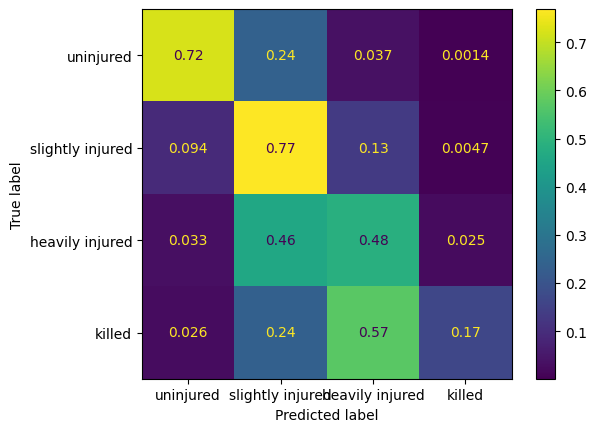

In [130]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'slightly injured', 'heavily injured', 'killed'],
).plot()

## Isotonic Regression

In [ ]:
# y in {0,1,...,K-1}; s_val = regressor predictions on a *validation* set
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols),
], remainder='passthrough')

iso = IsotonicRegression(y_min=1, y_max=None, increasing=True, out_of_bounds="clip")

pipeline = Pipeline([
    ('pre', transformer),
    ('reg', iso)
])

pipeline.fit(X_train, y_train)

def predict_classes(s):
    y_hat = np.rint(iso.predict(s))        # round to nearest integer
    return np.clip(y_hat, 1, 4).astype(int)

y_pred = predict_classes(X_test)

ValueError: Isotonic regression input X should be a 1d array or 2d array with 1 feature

In [ ]:
print(classification_report(y_test, y_pred))

## EasyEnsembleClassifier

In [18]:
from imblearn.ensemble import EasyEnsembleClassifier

In [19]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols),
], remainder='passthrough')

pipeline = Pipeline([
    ('pre', transformer),
    ('en', EasyEnsembleClassifier(random_state=42, n_jobs=-1))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [32] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.73      0.66      0.69     48829
           2       0.56      0.45      0.50     45378
           3       0.32      0.33      0.33     17845
           4       0.10      0.53      0.17      3143

    accuracy                           0.52    115195
   macro avg       0.43      0.49      0.42    115195
weighted avg       0.58      0.52      0.54    115195



## Balanced Random Forest Classifier

In [62]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [90]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', StandardScaler(), num_cols),
], remainder='passthrough')

cat_cols_idx = [X_train.columns.get_loc(x) for x in cat_cols]

pipeline = ImbPipeline([
    ('pre', transformer),
    ('en', BalancedRandomForestClassifier(n_jobs=-1, n_estimators=100, sampling_strategy='all', replacement=True, bootstrap=True))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [32] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.82      0.77      0.80     48829
           2       0.68      0.55      0.61     45378
           3       0.38      0.47      0.42     17845
           4       0.17      0.57      0.27      3143

    accuracy                           0.63    115195
   macro avg       0.51      0.59      0.52    115195
weighted avg       0.68      0.63      0.65    115195



## BalancedBaggingClassifier

In [72]:
from imblearn.ensemble import BalancedBaggingClassifier

In [73]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', StandardScaler(), num_cols),
], remainder='passthrough')

pipeline = Pipeline([
    ('pre', transformer),
    ('en', BalancedBaggingClassifier(n_estimators=100, n_jobs=8))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [32] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.74      0.79     48829
           2       0.65      0.58      0.62     45378
           3       0.38      0.47      0.42     17845
           4       0.17      0.52      0.25      3143

    accuracy                           0.63    115195
   macro avg       0.51      0.58      0.52    115195
weighted avg       0.68      0.63      0.65    115195



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Optional UMAP (if installed)
try:
    import umap
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False

# Build preprocessing to numeric space
pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), [c for c in X_train.columns if c not in num_cols]),
    ('num', StandardScaler(), num_cols),
], remainder='drop')

# Fit on train+test for a shared embedding space
X_all = pd.concat([X_train, X_test], axis=0, ignore_index=True)
y_all = pd.concat([y_train, y_test], axis=0, ignore_index=True)

X_all_num = pre.fit_transform(X_all)

# Choose method: 'pca', 'tsne', or 'umap' (if available)
method = 'tsne'  # change to 'tsne' or 'umap' as needed
rs = 42

if method == 'pca':
    reducer = PCA(n_components=2, random_state=rs)
    Z = reducer.fit_transform(X_all_num)
elif method == 'tsne':
    # t-SNE can be slow; consider subsampling for very large datasets
    reducer = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=rs, verbose=0, n_jobs=-1)
    Z = reducer.fit_transform(X_all_num)
elif method == 'umap' and HAS_UMAP:
    reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=rs)
    Z = reducer.fit_transform(X_all_num)
else:
    raise ValueError("Set method to 'pca', 'tsne', or 'umap' (install umap-learn).")

# Optional: subsample for plotting speed
max_points = 40000
if Z.shape[0] > max_points:
    rng = np.random.RandomState(rs)
    idx = rng.choice(Z.shape[0], size=max_points, replace=False)
    Zp = Z[idx]
    yp = y_all.iloc[idx].to_numpy()
else:
    Zp = Z
    yp = y_all.to_numpy()

# Prepare a small helper for labels/colors
label_names = {1:'not injured', 2:'slightly injured', 3:'heavily injured', 4:'killed'}
colors = {1:'#4e79a7', 2:'#59a14f', 3:'#f28e2b', 4:'#e15759'}

plt.figure(figsize=(8, 6))
for k in sorted(np.unique(yp)):
    m = (yp == k)
    plt.scatter(Zp[m, 0], Zp[m, 1], s=6, alpha=0.5, c=colors.get(k, '#888888'), label=label_names.get(k, str(k)))
plt.title(f'2D representation with {method.upper()}')
plt.xlabel('dim-1')
plt.ylabel('dim-2')
plt.legend(markerscale=3, fontsize=9, frameon=True)
plt.tight_layout()
plt.show()

# Keep for later use if needed
embed_2d = pd.DataFrame({'x': Z[:, 0], 'y': Z[:, 1], 'label': y_all.to_numpy()})

TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'